# Exercise 5 : ResNet with Subclassing & Sequential APIs

In [41]:
from tensorflow.python.framework.test_util import device
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at : {}'.format(device_name))

Found GPU at : /device:GPU:0


In [42]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [43]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation = "relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
                            keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias = False),
                            keras.layers.BatchNormalization(),
                            self.activation,
                            keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
                            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                                keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                                keras.layers.BatchNormalization()]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
                skip_Z = layer(skip_Z)
        return self.activation(Z+skip_Z)

In [44]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(64, 7, strides = 2, input_shape = [28,28,1], padding = "same", use_bias = False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = "same"))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filter == prev_filters else 2
    model.add(ResidualUnit(filters, strides = strides))
    prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation = "softmax"))

In [45]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_300 (Conv2D)         (None, 14, 14, 64)        3136      
                                                                 
 batch_normalization_300 (Ba  (None, 14, 14, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_6 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 residual_unit_96 (ResidualU  (None, 4, 4, 64)         78592     
 nit)                                                            
                                                      

# Exercise 6 : Training ResNet-34 for Fashion MNIST

In [46]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis = 0, keepdims=True)
X_std = X_train.std(axis=0, keepdims = True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs = 10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 279s 147ms/step - loss: 0.8734 - accuracy: 0.6976 - val_loss: 0.6277 - val_accuracy: 0.7868
Epoch 2/10
1719/1719 [==============================] - 251s 146ms/step - loss: 0.6045 - accuracy: 0.7955 - val_loss: 0.5401 - val_accuracy: 0.8192
Epoch 3/10
1719/1719 [==============================] - 249s 145ms/step - loss: 0.5583 - accuracy: 0.8179 - val_loss: 0.4636 - val_accuracy: 0.8436
Epoch 4/10
1719/1719 [==============================] - 249s 145ms/step - loss: 0.5192 - accuracy: 0.8287 - val_loss: 0.5416 - val_accuracy: 0.8272
Epoch 5/10
1719/1719 [==============================] - 249s 145ms/step - loss: 0.5000 - accuracy: 0.8376 - val_loss: 0.5134 - val_accuracy: 0.8130
Epoch 6/10
1719/1719 [==============================] - 249s 145ms/step - loss: 0.4509 - accuracy: 0.8517 - val_loss: 0.4147 - val_accuracy: 0.8676
Epoch 7/10
1719/1719 [==============================] - 248s 144ms/step - loss: 0.4016 - accuracy: 0.8683 - val_

In [47]:
X_new = X_test[:10]
y_pred = model.predict(X_new)

# Exercise 7 : Training ResNet-34 for CIFAR10

In [48]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [49]:
def visualize_data(images, categories, class_names):
    fig = plt.figure(figsize=(14,6))
    fig.patch.set_facecolor('white')
    for i in range(3*7):
        plt.subplot(3, 7, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        class_index = categories[i].argmax()
        plt.xlabel(class_names[class_index])
    plt.show()

In [50]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes)

x_test = x_test / 255.0
y_test = to_categorical(y_test, num_classes)

(50000, 32, 32, 3) (50000, 10)


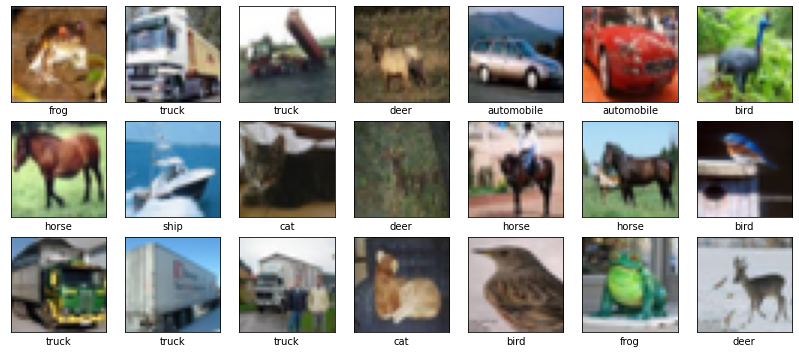

In [51]:
print(x_train.shape, y_train.shape)
visualize_data(x_train, y_train, class_names)

In [52]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides = 2, input_shape = [32, 32, 3], padding = "same", use_bias=False))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding = "same"))

prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=10, validation_data = (x_test, y_test))
score = model.evaluate(x_test, y_test)

Epoch 1/10
1563/1563 [==============================] - 238s 145ms/step - loss: 1.5255 - accuracy: 0.4687 - val_loss: 1.7036 - val_accuracy: 0.4140
Epoch 2/10
1563/1563 [==============================] - 226s 144ms/step - loss: 1.1513 - accuracy: 0.5999 - val_loss: 3.3435 - val_accuracy: 0.4533
Epoch 3/10
1563/1563 [==============================] - 225s 144ms/step - loss: 0.9872 - accuracy: 0.6588 - val_loss: 1.1512 - val_accuracy: 0.6056
Epoch 4/10
1563/1563 [==============================] - 226s 144ms/step - loss: 0.8322 - accuracy: 0.7145 - val_loss: 0.9989 - val_accuracy: 0.6535
Epoch 5/10
1563/1563 [==============================] - 225s 144ms/step - loss: 0.7539 - accuracy: 0.7414 - val_loss: 1.0115 - val_accuracy: 0.6624
Epoch 6/10
1563/1563 [==============================] - 226s 145ms/step - loss: 0.6542 - accuracy: 0.7775 - val_loss: 0.8527 - val_accuracy: 0.7147
Epoch 7/10
1563/1563 [==============================] - 225s 144ms/step - loss: 0.5798 - accuracy: 0.8052 - val_

# Exercise 8 : CIFAR10 Dataset with Data Augmentation

In [53]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

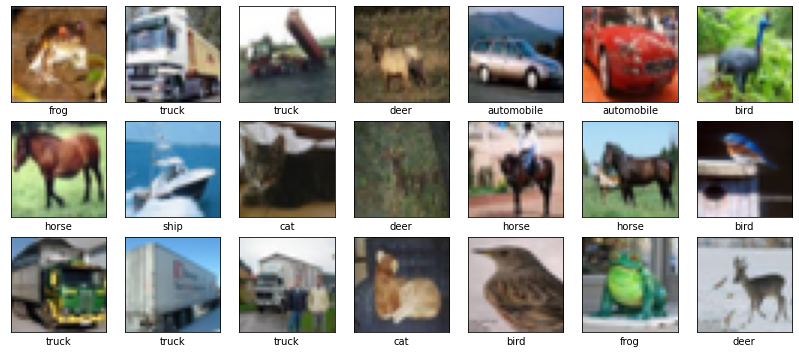

In [54]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes)

x_test = x_test / 255.0
y_test = to_categorical(y_test, num_classes)

visualize_data(x_train, y_train, class_names)

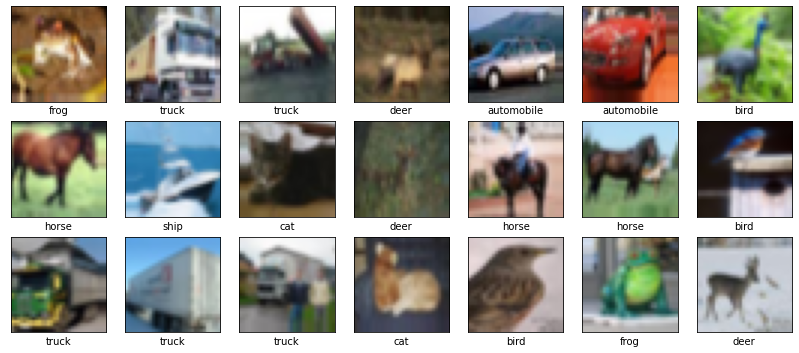

In [55]:
width_shift = 3/32
height_shift = 3/32
flip = True

datagen = ImageDataGenerator(
    horizontal_flip=flip,
    width_shift_range=width_shift,
    height_shift_range=height_shift,
)
datagen.fit(x_train)

it = datagen.flow(x_train, y_train, shuffle=False)
batch_images, batch_labels = next(it)
visualize_data(batch_images, batch_labels, class_names)

In [56]:
train_datagen = ImageDataGenerator(horizontal_flip=flip, width_shift_range=width_shift, height_shift_range=height_shift)
valid_datagen = ImageDataGenerator(rescale = 1)

train_generator = train_datagen.flow(x_train, y = y_train, batch_size=32)
valid_generator = train_datagen.flow(x_test, y = y_test, batch_size=32)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(train_generator, epochs = 10, validation_data = valid_generator)
score = model.evaluate(x_test, y_test)

Epoch 1/10
1563/1563 [==============================] - 250s 152ms/step - loss: 0.7049 - accuracy: 0.7620 - val_loss: 0.9026 - val_accuracy: 0.6960
Epoch 2/10
1563/1563 [==============================] - 237s 152ms/step - loss: 0.6512 - accuracy: 0.7800 - val_loss: 2.3679 - val_accuracy: 0.3738
Epoch 3/10
1563/1563 [==============================] - 236s 151ms/step - loss: 0.6421 - accuracy: 0.7820 - val_loss: 0.8183 - val_accuracy: 0.7237
Epoch 4/10
1563/1563 [==============================] - 238s 152ms/step - loss: 0.5984 - accuracy: 0.7972 - val_loss: 1.3529 - val_accuracy: 0.5770
Epoch 5/10
1563/1563 [==============================] - 239s 153ms/step - loss: 0.6355 - accuracy: 0.7836 - val_loss: 0.6990 - val_accuracy: 0.7644
Epoch 6/10
1563/1563 [==============================] - 239s 153ms/step - loss: 0.5774 - accuracy: 0.8050 - val_loss: 0.7020 - val_accuracy: 0.7646
Epoch 7/10
1563/1563 [==============================] - 238s 152ms/step - loss: 0.5742 - accuracy: 0.8031 - val_

# Exercise 9 : Training ResNet-50 with Augmented CIFAR10

In [57]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [64]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation = "relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
                            keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias = False),
                            keras.layers.BatchNormalization(),
                            self.activation,
                            keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
                            keras.layers.BatchNormalization(),
                            self.activation,
                            keras.layers.Conv2D(filters * 4, 1, strides=1, padding="same", use_bias=False),
                            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                                keras.layers.Conv2D(filters * 4, 1, strides=strides, padding="same", use_bias=False),
                                keras.layers.BatchNormalization()]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
                skip_Z = layer(skip_Z)
        return self.activation(Z+skip_Z)

In [65]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(64, 7, strides = 2, input_shape = [28,28,1], padding = "same", use_bias = False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = "same"))

prev_filters = 0
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filter == prev_filters else 2
    model.add(ResidualUnit(filters, strides = strides))
    prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation = "softmax"))

In [67]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs = 16, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)

Epoch 1/16
1719/1719 [==============================] - 342s 187ms/step - loss: 1.1768 - accuracy: 0.5980 - val_loss: 0.7571 - val_accuracy: 0.7362
Epoch 2/16
1719/1719 [==============================] - 319s 185ms/step - loss: 0.8187 - accuracy: 0.7222 - val_loss: 0.6388 - val_accuracy: 0.7748
Epoch 3/16
1719/1719 [==============================] - 320s 186ms/step - loss: 0.7494 - accuracy: 0.7536 - val_loss: 0.9687 - val_accuracy: 0.7184
Epoch 4/16
1719/1719 [==============================] - 321s 186ms/step - loss: 0.8019 - accuracy: 0.7331 - val_loss: 3.3889 - val_accuracy: 0.2464
Epoch 5/16
1719/1719 [==============================] - 321s 187ms/step - loss: 0.8699 - accuracy: 0.6921 - val_loss: 1.3714 - val_accuracy: 0.6694
Epoch 6/16
1719/1719 [==============================] - 322s 187ms/step - loss: 0.6566 - accuracy: 0.7719 - val_loss: 0.8836 - val_accuracy: 0.6818
Epoch 7/16
1719/1719 [==============================] - 323s 188ms/step - loss: 0.7307 - accuracy: 0.7508 - val_